C:\Users\mzkolk\AppData\Local\Temp\ipykernel_14352\2267342063.py:7: DtypeWarning: Columns (66,76) have mixed types. Specify dtype option on import or set low_memory=False.
  lifelines =  pd.read_csv(r'Lifeline_v2_AT_AE.csv', index_col=[0])


{'Log-like': 285.3022799497503, 'AIC': 12307.432061544021}


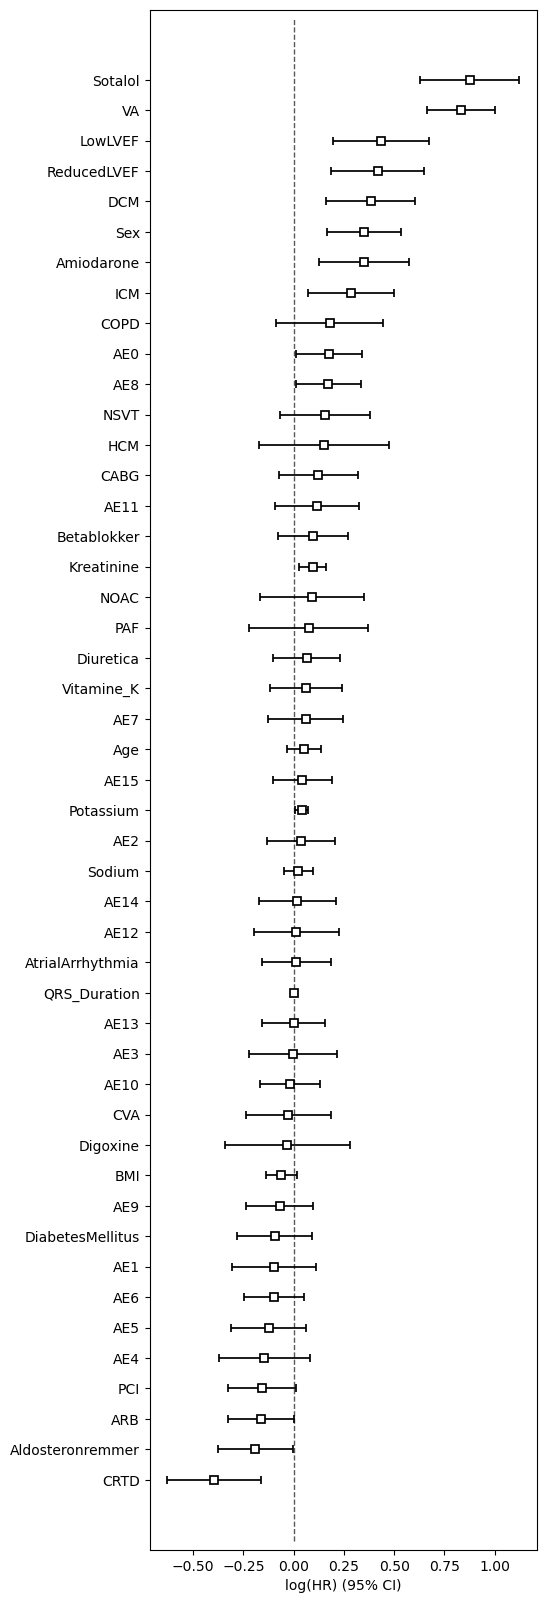

In [20]:
import pandas as pd
import numpy as np
from lifelines import CoxTimeVaryingFitter
from lifelines import CoxTimeVaryingFitter, utils
import matplotlib.pyplot as plt

lifelines =  pd.read_csv(r'Lifeline_v2_AT_AE.csv', index_col=[0])

tru = lifelines.drop(labels = ['SeriesInstanceUID', 'StudyDate', 'StudyID_x', 'Date_ICD_implantatie'], axis=1)


# Rename columns that are numbers
column_names = {}
for col in tru.columns:
    if col.isnumeric():
        column_names[col] = 'AE{}'.format(col)
tru = tru.rename(columns=column_names)

tru = tru.rename(columns={
    'Antiaritmica_soort#Sotalol': 'Sotalol',
    'Antiaritmica_soort#Digoxine': 'Digoxine',
    'Antiaritmica_soort#Amiodarone': 'Amiodarone',
    '1st degree AV block' : 'AVblock'
})


cols_to_scale = ["Age", "BMI", "Sodium", "Potassium", "Kreatinine"]


#Scaling data ECG
scaling_set = tru[cols_to_scale]
features_mean = scaling_set.mean()
features_std = scaling_set.std()
scaling_set=((scaling_set-features_mean)/features_std)
tru[cols_to_scale]= scaling_set

survival_table = tru 
    
survival_table = survival_table.drop(survival_table[(survival_table['start'] == 0) & (survival_table['stop'] == 0)].index)

# Assuming 'tru' is a DataFrame with the necessary columns

survival_table['VA'] = ((survival_table['VF'] == 1) | (survival_table['SustVT'] == 1)).astype(int)

#print(survival_table.loc[(survival_table['Event'] == True) & (survival_table['start'] == 0) &  (survival_table['stop'] == 0)])


formula = "Age + Sex + AtrialArrhythmia + VA + NSVT + ICM + DCM + HCM + LowLVEF + ReducedLVEF + QRS_Duration + CRTD + PCI + CABG + PAF + CVA + COPD + DiabetesMellitus + BMI + Kreatinine  + Vitamine_K + Sotalol + Digoxine + Amiodarone +  Sodium + Potassium + Betablokker +  ARB  + Diuretica + NOAC + Aldosteronremmer + AE0 + AE1 + AE2 + AE3 + AE4 + AE5 + AE6 + AE7 + AE8 + AE9 + AE10 + AE11 + AE12 + AE13 + AE14 + AE15"
#formula_int =  "Age + Sex + AtrialArrhythmia + VF + SustVT + NSVT + ICM + DCM + HCM + NICM + PAS + LowLVEF + ReducedLVEF + CRTD + PCI + CABG + MyocardialInfarction + CVA + COPD + DiabetesMellitus + BMI + Kreatinine  + Vitamine_K + Sotalol + Digoxine + Amiodarone + Betablokker +  ARB  + Diuretica + NOAC + Aldosteronremmer + ST + SB + AF + LBBB + RBBB "
#formula = "AE0 + AE1 + AE2 + AE3 + AE4 + AE5 + AE6 + AE7 + AE8 + AE9 + AE10 + AE11 + AE12 + AE13 + AE14 + AE15"
#formula_clin = "Age + Sex + AtrialArrhythmia + VF + SustVT + NSVT + ICM + DCM + HCM + NICM + PAS + LowLVEF + ReducedLVEF + CRTD + PCI + CABG + MyocardialInfarction + CVA + COPD + DiabetesMellitus + BMI + Kreatinine  + Vitamine_K + Sotalol + Digoxine + Amiodarone + Betablokker +  ARB  + Diuretica + NOAC + Aldosteronremmer"
# print summary of the model

# initialize CoxTimeVaryingFitter
ctv = CoxTimeVaryingFitter(alpha = 0.05)#, penalizer=0.001)


ctv.fit(survival_table, event_col='Event', start_col='start', stop_col='stop', show_progress=False, 
      formula=formula,  id_col="PatientID")



results_dict = {
    'Log-like': ctv.log_likelihood_ratio_test().test_statistic,
    'AIC' : ctv.AIC_partial_   
 }

results_df = pd.DataFrame(results_dict, index=[0])

print(results_dict)

ctv.summary.sort_values(by=['p'], ascending=False)
plt.figure(figsize=(5, 20))
ctv.plot()
#plt.savefig(r"Forestplot_timevaryingcox.pdf", dpi=400, bbox_inches='tight')
#plt.savefig(r"Forestplot_timevaryingcox.tiff", dpi=400, bbox_inches='tight')

plt.show()
plt.close()

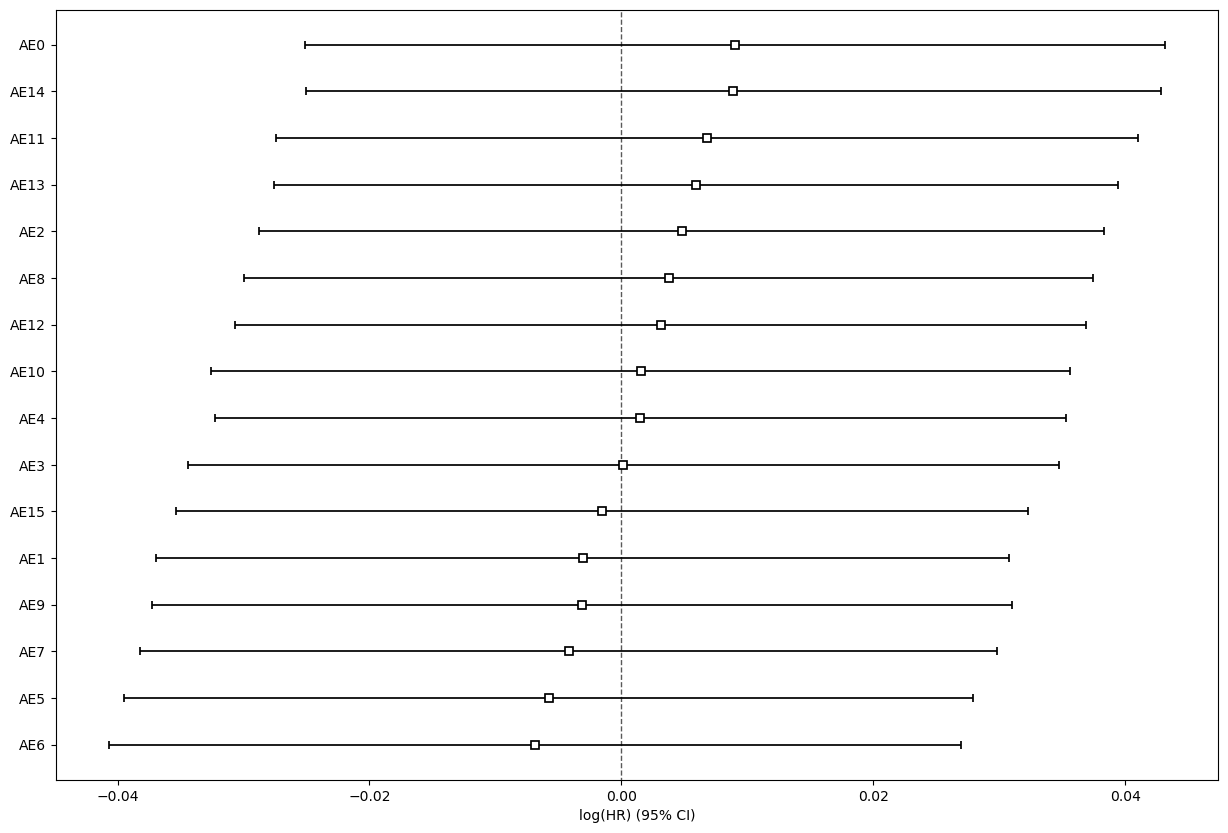

In [13]:
plt.figure(figsize=(15, 10))
ctv.plot()
#plt.savefig(r"Forestplot_timevaryingcox.pdf", dpi=400, bbox_inches='tight')
#plt.savefig(r"Forestplot_timevaryingcox.tiff", dpi=400, bbox_inches='tight')

plt.show()
plt.close()

In [3]:
round(ctv.summary[['exp(coef)', 'exp(coef) lower 95%','exp(coef) upper 95%',  'p']].sort_values(by=['p'], ascending=True) ,2)


,exp(coef),exp(coef) lower 95%,exp(coef) upper 95%,p
covariate,,,,
VA,2.30,1.94,2.73,0.00
Sotalol,2.40,1.88,3.08,0.00
Sex,1.42,1.18,1.70,0.00
LowLVEF,1.54,1.22,1.96,0.00
ReducedLVEF,1.52,1.20,1.91,0.00
DCM,1.47,1.18,1.83,0.00
CRTD,0.67,0.53,0.85,0.00
Amiodarone,1.42,1.13,1.77,0.00
Kreatinine,1.10,1.03,1.18,0.01


In [15]:
print(list(lifelines))

['PatientID', 'start', '0', '1', '10', '11', '12', '13', '14', '15', '1st degree AV block', '2', '3', '4', '5', '6', '7', '8', '9', 'AF', 'ARB', 'Age', 'Aldosteronremmer', 'Antiaritmica_soort#Amiodarone', 'Antiaritmica_soort#Digoxine', 'Antiaritmica_soort#Sotalol', 'AppropriateTherapy', 'AtrialArrhythmia', 'BMI', 'Betablokker', 'CABG', 'CHD', 'COPD', 'CRTD', 'CVA', 'DCM', 'DR', 'Date_ICD_implantatie', 'DiabetesMellitus', 'Diuretica', 'Dyslipedaemia', 'HCM', 'Hypertension', 'ICM', 'Implantation_indication', 'Kreatinine', 'LBBB', 'LowLVEF', 'MonthsTillAppropriateTherapy', 'MyocardialInfarction', 'NICM', 'NOAC', 'NSVT', 'NormalLVEF', 'OHCA', 'PAF', 'PAS', 'PCI', 'Potassium', 'QRS_Duration', 'RBBB', 'ReducedLVEF', 'SB', 'SICD', 'ST', 'SeriesInstanceUID', 'Sex', 'Sodium', 'StudyDate', 'StudyID_x', 'SustVT', 'VF', 'VR', 'Vitamine_K', 'stop', 'Event']


C:\Users\mzkolk\AppData\Local\Temp\ipykernel_14352\3778546703.py:7: DtypeWarning: Columns (82,92) have mixed types. Specify dtype option on import or set low_memory=False.
  lifelines =  pd.read_csv(r'Lifeline_v2_AT_AE_32.csv', index_col=[0])


{'Log-like': 286.3138992528002, 'AIC': 12338.420442240971}


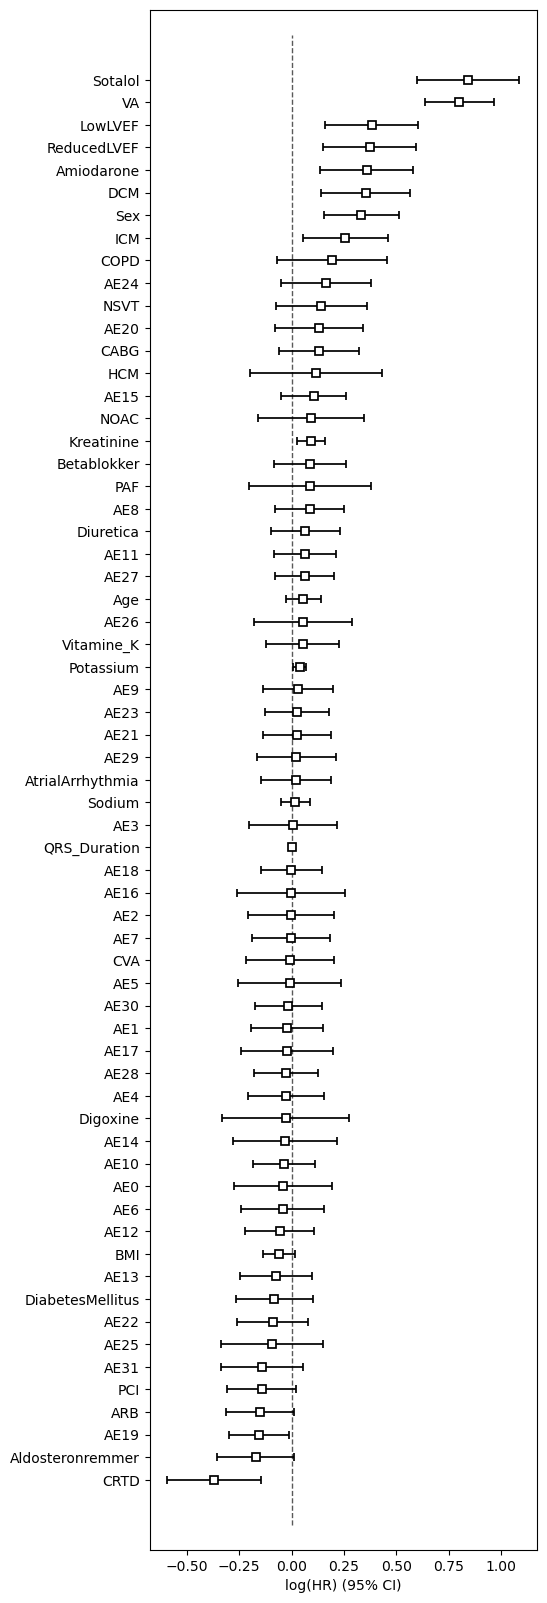

In [17]:
import pandas as pd
import numpy as np
from lifelines import CoxTimeVaryingFitter
from lifelines import CoxTimeVaryingFitter, utils
import matplotlib.pyplot as plt

lifelines =  pd.read_csv(r'Lifeline_v2_AT_AE_32.csv', index_col=[0])

tru = lifelines.drop(labels = ['SeriesInstanceUID', 'StudyDate', 'StudyID_x', 'Date_ICD_implantatie'], axis=1)


# Rename columns that are numbers
column_names = {}
for col in tru.columns:
    if col.isnumeric():
        column_names[col] = 'AE{}'.format(col)
tru = tru.rename(columns=column_names)

tru = tru.rename(columns={
    'Antiaritmica_soort#Sotalol': 'Sotalol',
    'Antiaritmica_soort#Digoxine': 'Digoxine',
    'Antiaritmica_soort#Amiodarone': 'Amiodarone',
    '1st degree AV block' : 'AVblock'
})


cols_to_scale = ["Age", "BMI", "Sodium", "Potassium", "Kreatinine"]


#Scaling data ECG
scaling_set = tru[cols_to_scale]
features_mean = scaling_set.mean()
features_std = scaling_set.std()
scaling_set=((scaling_set-features_mean)/features_std)
tru[cols_to_scale]= scaling_set

survival_table = tru 
    
survival_table = survival_table.drop(survival_table[(survival_table['start'] == 0) & (survival_table['stop'] == 0)].index)

# Assuming 'tru' is a DataFrame with the necessary columns

survival_table['VA'] = ((survival_table['VF'] == 1) | (survival_table['SustVT'] == 1)).astype(int)

#print(survival_table.loc[(survival_table['Event'] == True) & (survival_table['start'] == 0) &  (survival_table['stop'] == 0)])


formula = "Age + Sex + AtrialArrhythmia + VA + NSVT + ICM + DCM + HCM + LowLVEF + ReducedLVEF + QRS_Duration + CRTD + PCI + CABG + PAF + CVA + COPD + DiabetesMellitus + BMI + Kreatinine  + Vitamine_K + Sotalol + Digoxine + Amiodarone +  Sodium + Potassium + Betablokker +  ARB  + Diuretica + NOAC + Aldosteronremmer + AE0 + AE1 + AE2 + AE3 + AE4 + AE5 + AE6 + AE7 + AE8 + AE9 + AE10 + AE11 + AE12 + AE13 + AE14 + AE15 + AE16 + AE17 + AE18 + AE19 + AE20 + AE21 + AE22 +AE23 + AE24 + AE25 + AE26 + AE27 + AE28 + AE29 + AE30 + AE31"
#formula_int =  "Age + Sex + AtrialArrhythmia + VF + SustVT + NSVT + ICM + DCM + HCM + NICM + PAS + LowLVEF + ReducedLVEF + CRTD + PCI + CABG + MyocardialInfarction + CVA + COPD + DiabetesMellitus + BMI + Kreatinine  + Vitamine_K + Sotalol + Digoxine + Amiodarone + Betablokker +  ARB  + Diuretica + NOAC + Aldosteronremmer + ST + SB + AF + LBBB + RBBB "
#formula = "AE0 + AE1 + AE2 + AE3 + AE4 + AE5 + AE6 + AE7 + AE8 + AE9 + AE10 + AE11 + AE12 + AE13 + AE14 + AE15"
#formula_clin = "Age + Sex + AtrialArrhythmia + VF + SustVT + NSVT + ICM + DCM + HCM + NICM + PAS + LowLVEF + ReducedLVEF + CRTD + PCI + CABG + MyocardialInfarction + CVA + COPD + DiabetesMellitus + BMI + Kreatinine  + Vitamine_K + Sotalol + Digoxine + Amiodarone + Betablokker +  ARB  + Diuretica + NOAC + Aldosteronremmer"
# print summary of the model

# initialize CoxTimeVaryingFitter
ctv = CoxTimeVaryingFitter(alpha = 0.05, penalizer=0.001)


ctv.fit(survival_table, event_col='Event', start_col='start', stop_col='stop', show_progress=False, 
      formula=formula,  id_col="PatientID")



results_dict = {
    'Log-like': ctv.log_likelihood_ratio_test().test_statistic,
    'AIC' : ctv.AIC_partial_   
 }

results_df = pd.DataFrame(results_dict, index=[0])

print(results_dict)

ctv.summary.sort_values(by=['p'], ascending=False)
plt.figure(figsize=(5, 20))
ctv.plot()
#plt.savefig(r"Forestplot_timevaryingcox.pdf", dpi=400, bbox_inches='tight')
#plt.savefig(r"Forestplot_timevaryingcox.tiff", dpi=400, bbox_inches='tight')

plt.show()
plt.close()